# I. Additional data compilation
 
In this script, I expand the training set by collecting data from reddit, goodreads, 
and additional Gutenberg project books. The provided training set had ~2000 examples. 
In this notebook, I managed to compile >90,000 examples.

In [1]:
import os
import numpy as np
import polars as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
#from plotting_preferences_AS import plotting_preferences_AS

In [2]:
#plotting_preferences_AS()

In [3]:
train = pl.read_csv("./data/train.csv")
train.head()

ID,TEXT,LABEL
i64,str,i64
0,"""When his speaker remained sile…",0
1,"""If she had only come to me and…",0
2,"""He took a step to a little mou…",0
3,"""The light of the torch flared …",0
4,"""""It's platinum,"" Carstairs sai…",0


### Checking distribution of text lengths in the existing dataset

In [4]:
(max_val := max([len(i) for i in train["TEXT"]]))

5491

In [5]:
[i for i in train["TEXT"] if len(i) == max_val]

['We are in this very like him, who having need of fire, went to a neighbour’s house to fetch it, and finding a very good one there, sat down to warm himself without remembering to carry any with him home.—[Plutarch, How a Man should Listen.]—What good does it do us to have the stomach full of meat, if it do not digest, if it be not incorporated with us, if it does not nourish and support us? Can we imagine that Lucullus, whom letters, without any manner of experience, made so great a captain, learned to be so after this perfunctory manner?—[Cicero, Acad., ii. I.]—We suffer ourselves to lean and rely so strongly upon the arm of another, that we destroy our own strength and vigour. Would I fortify myself against the fear of death, it must be at the expense of Seneca: would I extract consolation for myself or my friend, I borrow it from Cicero. I might have found it in myself, had I been trained to make use of my own reason. [SNIPPET] Of a truth I know not; Lothario alone was such a one,

In [6]:
(min([len(i) for i in train["TEXT"]]))

164

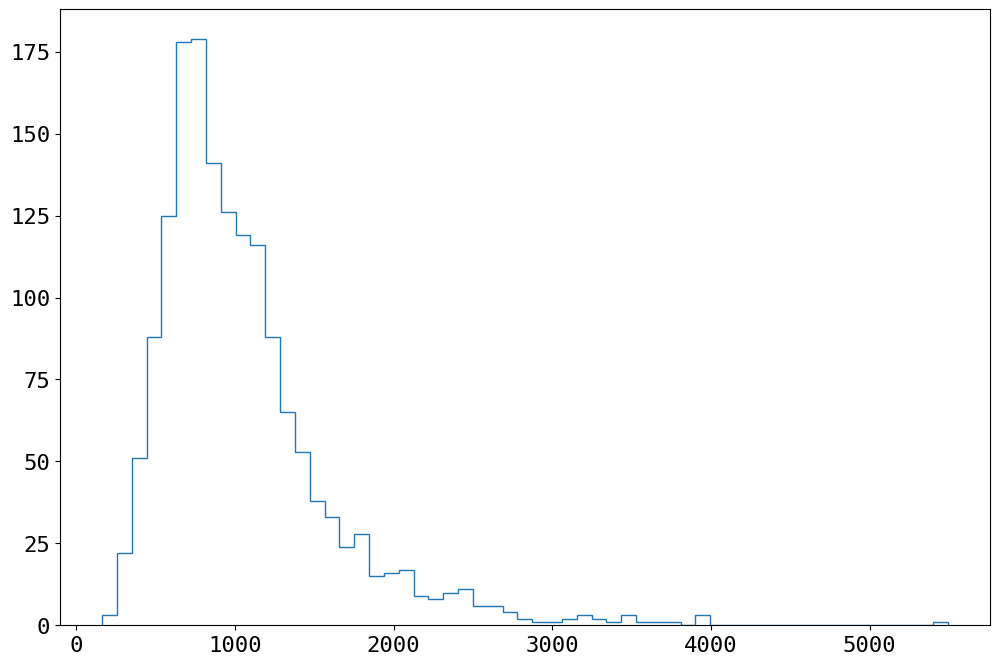

In [7]:
text_lengths = [len(i) for i in train["TEXT"]]

plt.hist(text_lengths, bins="fd", histtype="step")
plt.show()

In [8]:
np.quantile(text_lengths, 0.5)

np.float64(920.0)

### Creating a text list where all the chosen texts from various sources will be appended

In [9]:
MEGA_TEXT_LIST = []
TEXT_SOURCE_LIST = []

#### Checking Twitter data from [carblacac on huggingface](https://huggingface.co/datasets/carblacac/twitter-sentiment-analysis)

In [10]:
tweets = pl.read_csv(
    "./data/raw/train_150k.txt", 
    separator="\t",
    new_columns={"sentiment", "text"}
)

tweets

sentiment,text
i64,str
1,"""Sugar levels dropping... munch…"
1,"""@karineb22 yeah!!! have a grea…"
1,"""hannah montana was very good. …"
1,"""@Mayra326 aww, have fun! I ju…"
0,"""Worried about my cat. Took him…"
…,…
0,"""Had a great night at Tabs but …"
1,"""What a night at work.. Church …"
0,"""this book is terrible im used…"


In [11]:
# defining caption properties
caption_properties = FontProperties(family='serif', size=18)

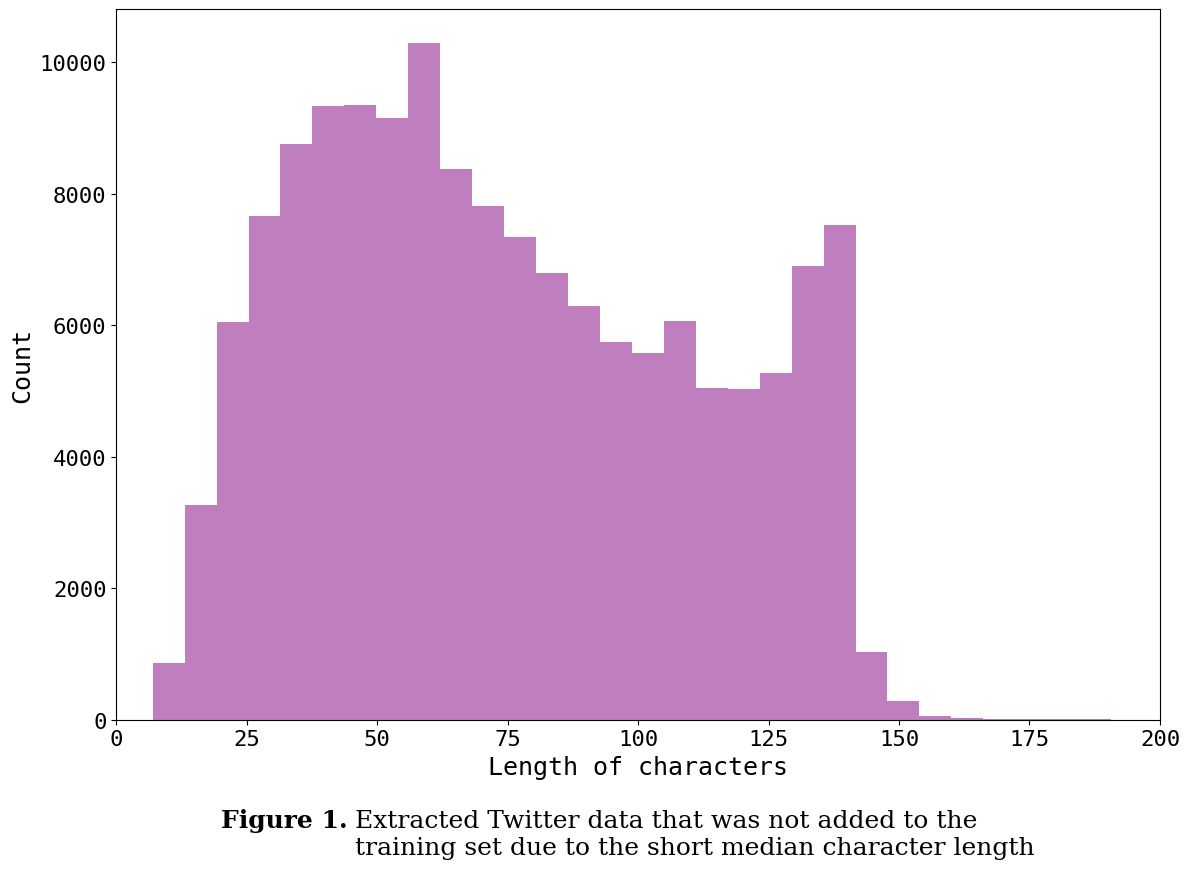

In [12]:
# printing length of tweets
col_of_interest = "sentiment" \
    if (tweets["text"][0] == 0 
        or tweets["text"][0] == 1) \
    else "text"
text_lengths = [len(i) for i in tweets[col_of_interest]]

plt.hist(text_lengths, bins="rice", histtype="stepfilled", alpha=0.5, color="purple")
plt.xlabel("character length")
plt.figtext(0.245, -0.0415, "Figure 1. ", ha='center',fontweight='bold',
            fontproperties=caption_properties)
plt.figtext(
    0.3, -0.075, 
    "Extracted Twitter data that was not added to the\n"
    "training set due to the short median character length", 
    ha='left', fontproperties=caption_properties
)

plt.xlim(0, 200)
plt.xlabel("Length of characters")
plt.ylabel("Count")

plt.tight_layout()

plt.savefig(
    "./plots/twitter_data_length.png",
    dpi=300,
    bbox_inches="tight"
)

Not ideal, the tweets are quite short; >280 character tweets have been a thing more 
recently, but mining Twitter data has become prohibitively expensive thanks to the 
south african entrepreneur.

#### Reddit data from [this Kaggle page](https://www.kaggle.com/datasets/prakharrathi25/reddit-data-huge?resource=download)

In [13]:
root = "./data/raw/reddit_data_huge/"
reddit_csv_names = [
    filenames for _, _, filenames 
    in os.walk("./data/raw/reddit_data_huge")
][0]
reddit_csv_paths = [root + i for i in reddit_csv_names]
print(len(reddit_csv_names))

31


**Note**: I deleted two files from the original list of files: a `.txt` file listing the names of all the subreddits and an improperly merged CSV with all the 31 CSVs plotted below. 

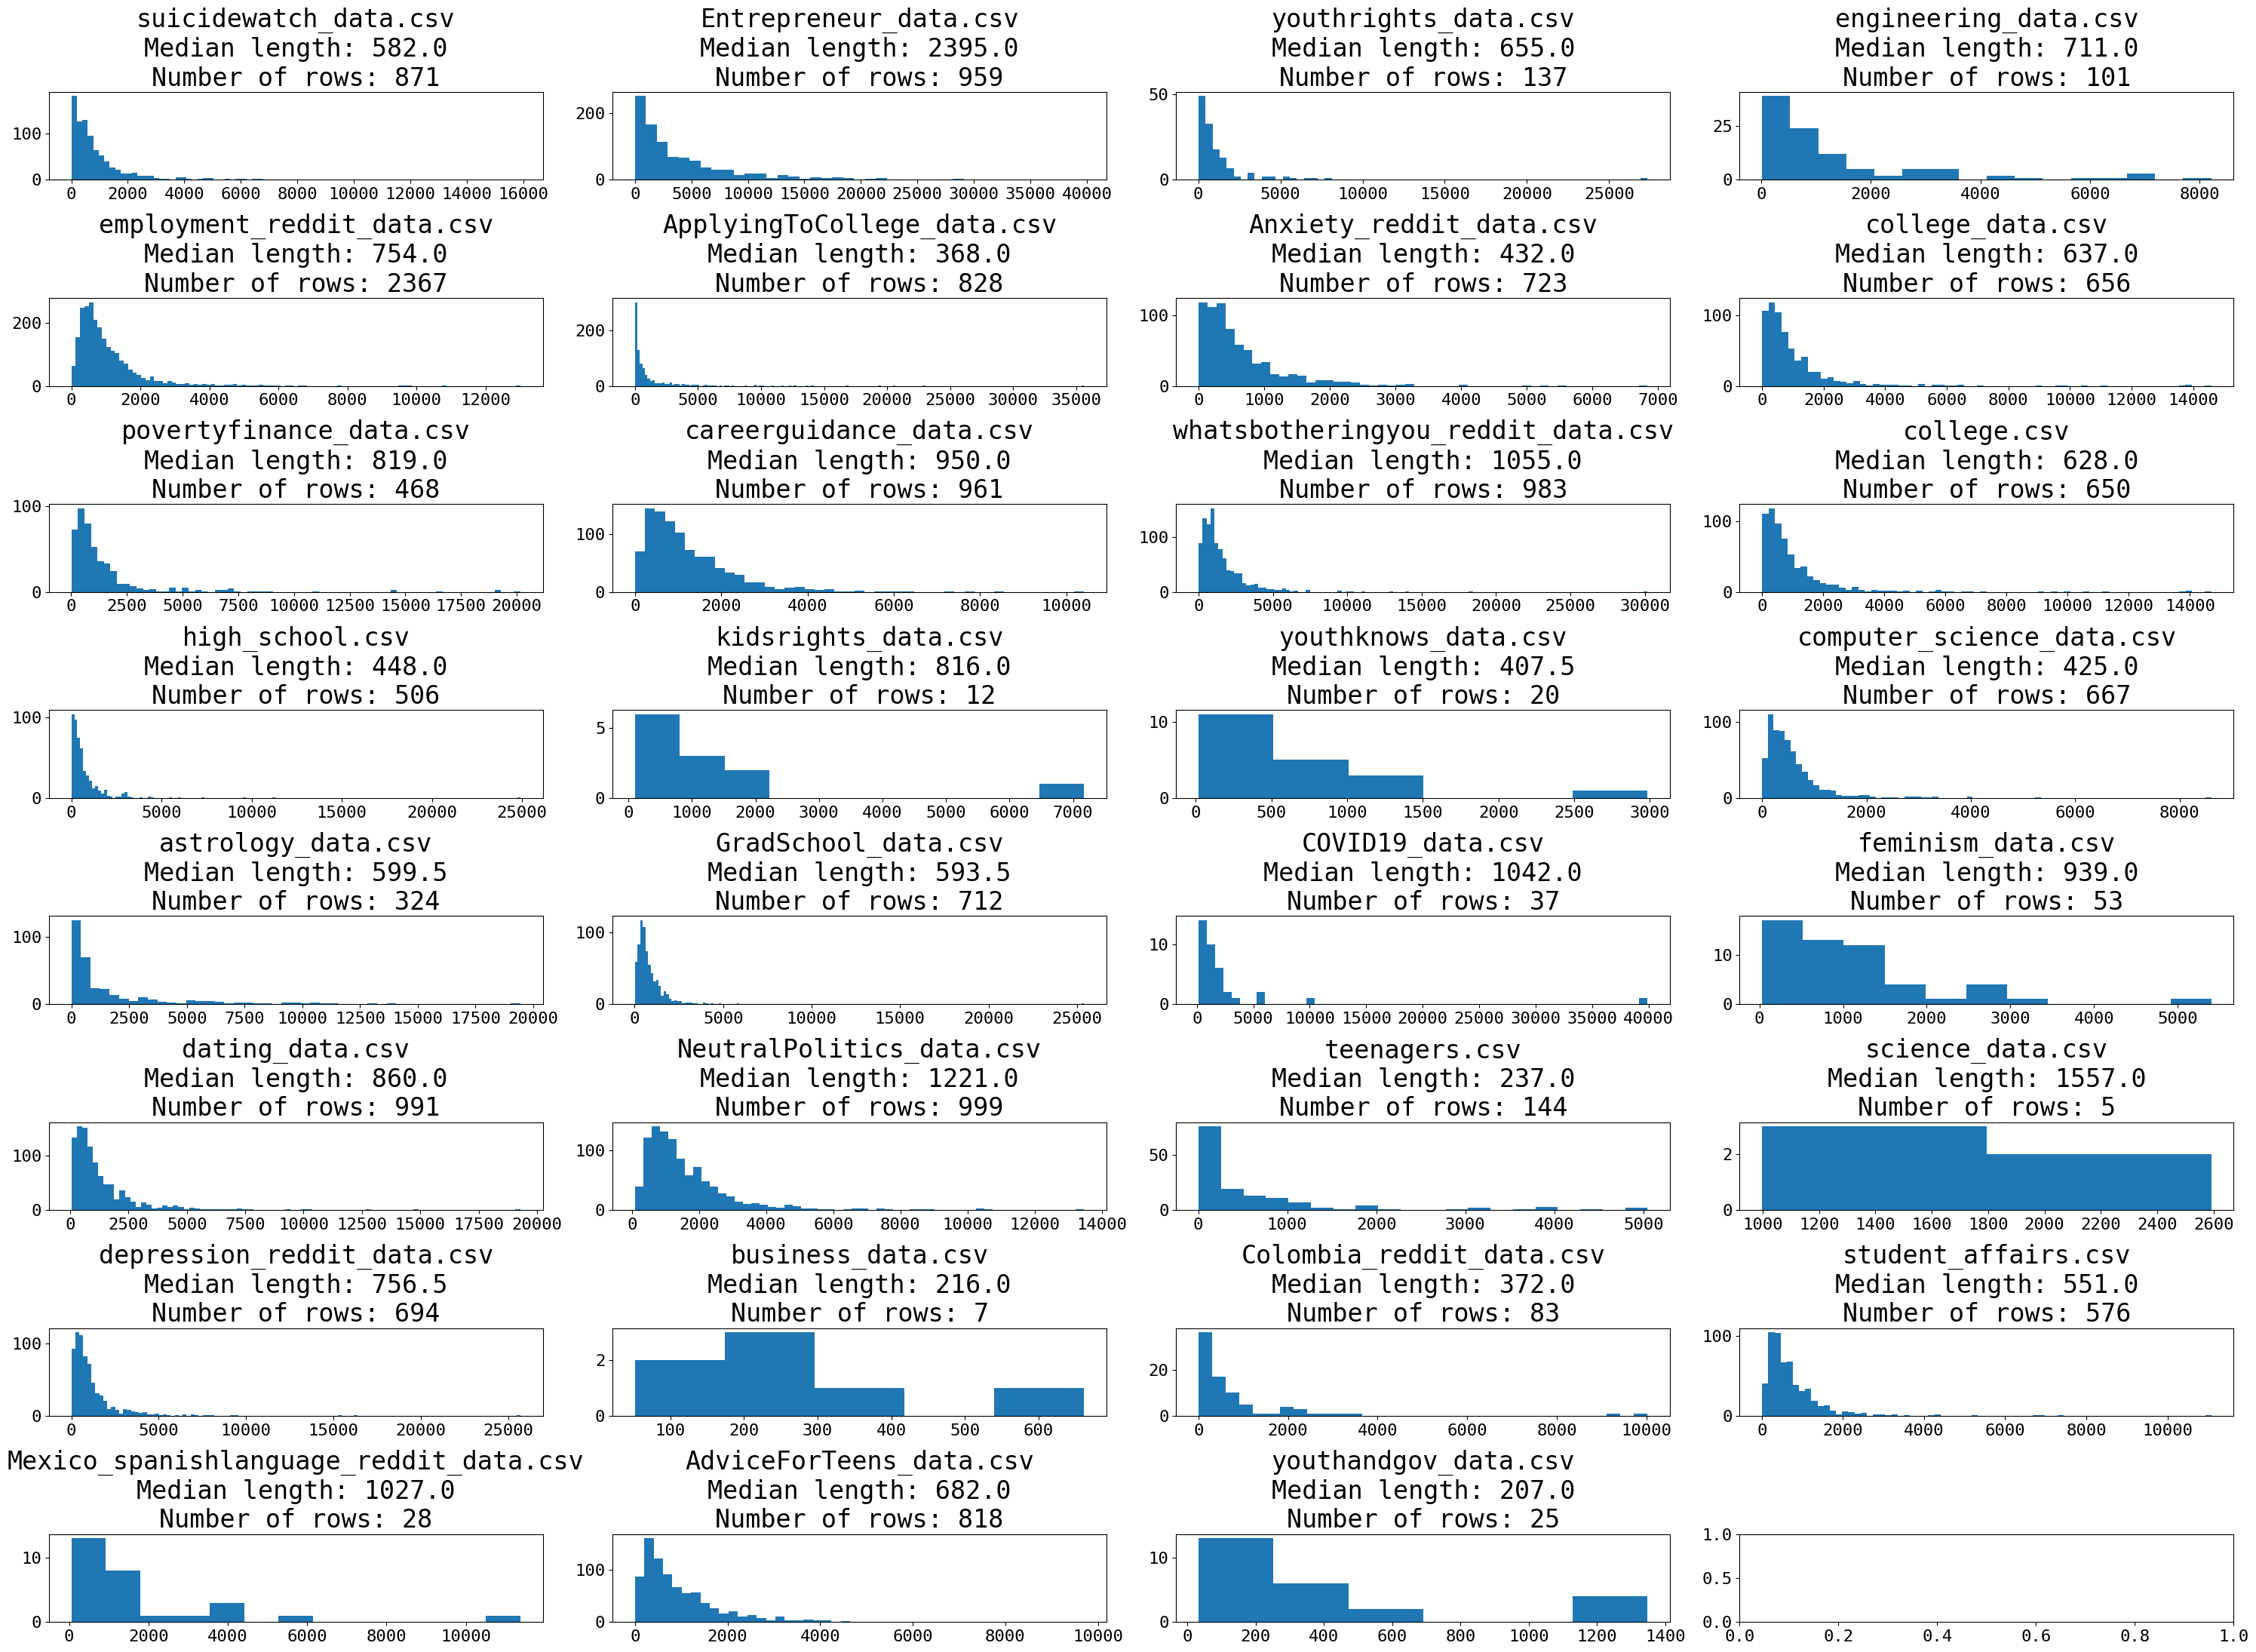

In [14]:
fig, ax = plt.subplots(8, 4, figsize=(30, 22))
ax = ax.flatten()

total_elements = 0

for i in range(len(reddit_csv_names)):
    list_of_text_lengths = [
        len(i) for i in pl.read_csv(reddit_csv_paths[i])["Body"] if i
    ]
    
    number_of_elements = len(list_of_text_lengths)
    total_elements += number_of_elements
    
    ax[i].hist(list_of_text_lengths, bins="fd")
    ax[i].set_title(
        f"{reddit_csv_names[i]}\n"
        f"Median length: {np.median(list_of_text_lengths)}\n"
        f"Number of rows: {number_of_elements}"
    )

plt.tight_layout()
plt.show()

In [15]:
# set to track uniqueness
seen_text = set()

reddit_data_text = []
reddit_data_text_subreddit = []

for df_name in reddit_csv_names:
    df_body = pl.read_csv(root + df_name)["Body"]
    
    # inefficient filtering of sentences
    body_text_not_null = [i for i in df_body if i]
    
    for text in body_text_not_null:
        if text not in seen_text:
            reddit_data_text.append(text)
            reddit_data_text_subreddit.append(df_name)
            seen_text.add(text)

print(len(reddit_data_text) == total_elements)
print(len(reddit_data_text) == len(set(reddit_data_text)))
print(len(reddit_data_text), len(reddit_data_text_subreddit))

False
True
16158 16158


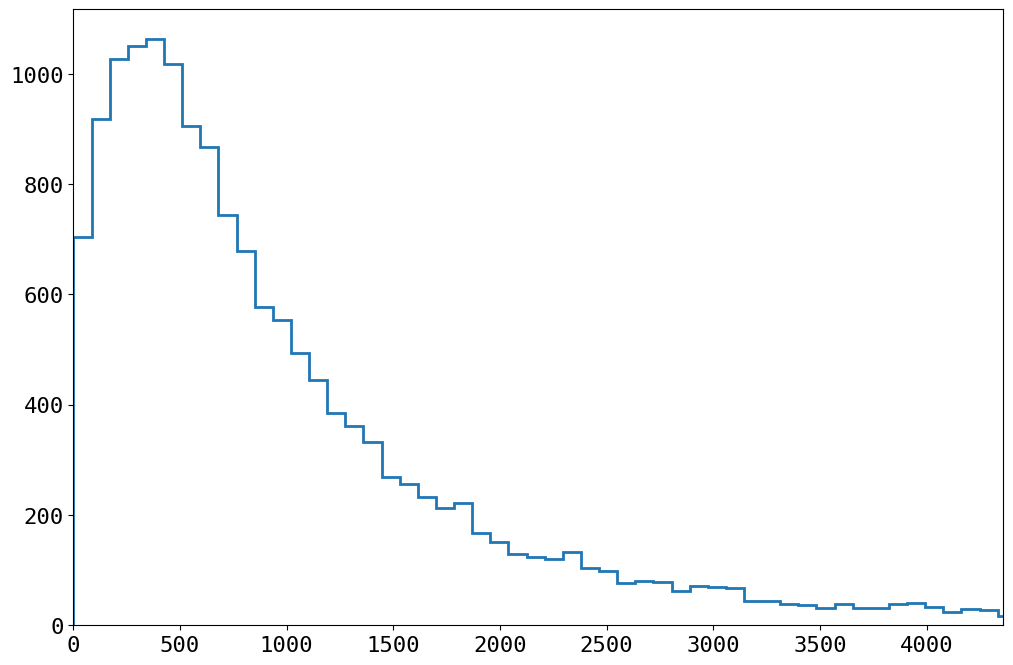

In [16]:
plt.hist([len(i) for i in reddit_data_text], bins="fd", histtype="step", lw=2)
plt.xlim(0, np.quantile([len(i) for i in reddit_data_text], 0.95))
plt.show()

In [17]:
reddit_data_text_subset = [
    [i, j] for i, j in zip(reddit_data_text, reddit_data_text_subreddit)
    if 300 <= len(i) <= 5000
]

print(
    "Number of reddit text with character lengths between 300-5000 is:",
    len(reddit_data_text_subset)
)

Number of reddit text with character lengths between 300-5000 is: 12320


In [18]:
### adding all reddit data with >=300 and <=5000 characters 
### 300 is double the minimum sentence length in the provided training set
### but it is sort of a random choice
MEGA_TEXT_LIST.extend([i[0] for i in reddit_data_text_subset])
TEXT_SOURCE_LIST.extend([i[1] for i in reddit_data_text_subset])

text_df = pl.DataFrame({
    "source": TEXT_SOURCE_LIST,
    "text": MEGA_TEXT_LIST
})

# saving the list as a csv
text_df.write_csv("./data/refined/mega_txt_list.csv")

#### Book reviews

I found a ~17 GB file with many book reviews from Goodreads ([source](https://mengtingwan.github.io/data/goodreads.html#datasets)).

In [19]:
 # lazily reading the large json
goodreads_lazy = pl.scan_ndjson("./data/raw/goodreads_reviews_dedup.json")
goodreads_lazy.collect_schema().names()

['user_id',
 'book_id',
 'review_id',
 'rating',
 'review_text',
 'date_added',
 'date_updated',
 'read_at',
 'started_at',
 'n_votes',
 'n_comments']

In [20]:
# selecting the reviews and the user ids, and collecting and saving them to a list
goodreads_reviews = goodreads_lazy.select(("user_id", "review_text"))
goodreads_reviews = goodreads_reviews.collect()
# goodreads_text_list = goodreads_reviews["review_text"].to_list()

In [21]:
print("Number of reviews:", len(goodreads_reviews))

Number of reviews: 15739967


That is a lot! For now, I will sample ~50,000 reviews from this list. That should bring
 the total collected text to ~60,000. Later, I will sample more text from blogs and 
 books, bring the total to ~100,000 samples. My naive guess is that this should be 
 sufficient to increase the performance of the model by a lot (after all, it is a 25-50x 
 increase is amount of fine-tuning data). If data continues to be a bottleneck, I can  
 always sample more reviews from this dataset.

In [22]:
# the "law of heavy tails" dictates that there must be goodreads reviewers who are super 
# into it and write more reviews than >99% of other users
goodreads_super_reviewers = (
    goodreads_lazy.select("user_id")
    .collect()
    .group_by("user_id")
    .count()
    .sort(by="count", descending=True)
 )[:20]

/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_75472/898531744.py:7: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


In [23]:
goodreads_super_reviewers

user_id,count
str,u32
"""a2d6dd1685e5aa0a72c9410f8f55e0…",21811
"""4922591667fd3e8adc0c5e3d42cf55…",10055
"""459a6c4decf925aedd08e45045c0d8…",9517
"""dd9785b14664103617304996541ed7…",7940
"""9003d274774f4c47e62f77600b08ac…",7765
…,…
"""422e76592e2717d5d59465d22d74d4…",4842
"""59151b639f247aa97fffd5c71701db…",4655
"""8273fc29780c84559cbd533fc969c0…",4525


In [24]:
sum(goodreads_super_reviewers["count"].to_list())

135887

In [25]:
goodreads_reviews_subset = goodreads_reviews.filter(
    pl.col("user_id").is_in(goodreads_super_reviewers["user_id"].to_list())
)

goodreads_reviews_subset

user_id,review_text
str,str
"""8e7e5b546a63cb9add8431ee6914cf…","""This Wicked Gift (A Carhart Se…"
"""8e7e5b546a63cb9add8431ee6914cf…","""The Maltese Falcon, The Thin M…"
"""8e7e5b546a63cb9add8431ee6914cf…","""Penguins of America - James Pa…"
"""8e7e5b546a63cb9add8431ee6914cf…","""I Shall Wear Midnight: A Story…"
"""8e7e5b546a63cb9add8431ee6914cf…","""I can only read a tiny bit at …"
…,…
"""e5905d648022af7b1309d82a1f4d25…","""This is a work along the lines…"
"""e5905d648022af7b1309d82a1f4d25…","""My life and those of many of t…"
"""e5905d648022af7b1309d82a1f4d25…","""I only began this oral history…"


In [26]:
goodreads_reviews_subset.insert_column(
    2, 
    pl.Series(
        "length",
        [len(i) for i in goodreads_reviews_subset["review_text"]]
    )
)

user_id,review_text,length
str,str,i64
"""8e7e5b546a63cb9add8431ee6914cf…","""This Wicked Gift (A Carhart Se…",1252
"""8e7e5b546a63cb9add8431ee6914cf…","""The Maltese Falcon, The Thin M…",728
"""8e7e5b546a63cb9add8431ee6914cf…","""Penguins of America - James Pa…",676
"""8e7e5b546a63cb9add8431ee6914cf…","""I Shall Wear Midnight: A Story…",892
"""8e7e5b546a63cb9add8431ee6914cf…","""I can only read a tiny bit at …",148
…,…,…
"""e5905d648022af7b1309d82a1f4d25…","""This is a work along the lines…",765
"""e5905d648022af7b1309d82a1f4d25…","""My life and those of many of t…",746
"""e5905d648022af7b1309d82a1f4d25…","""I only began this oral history…",1833


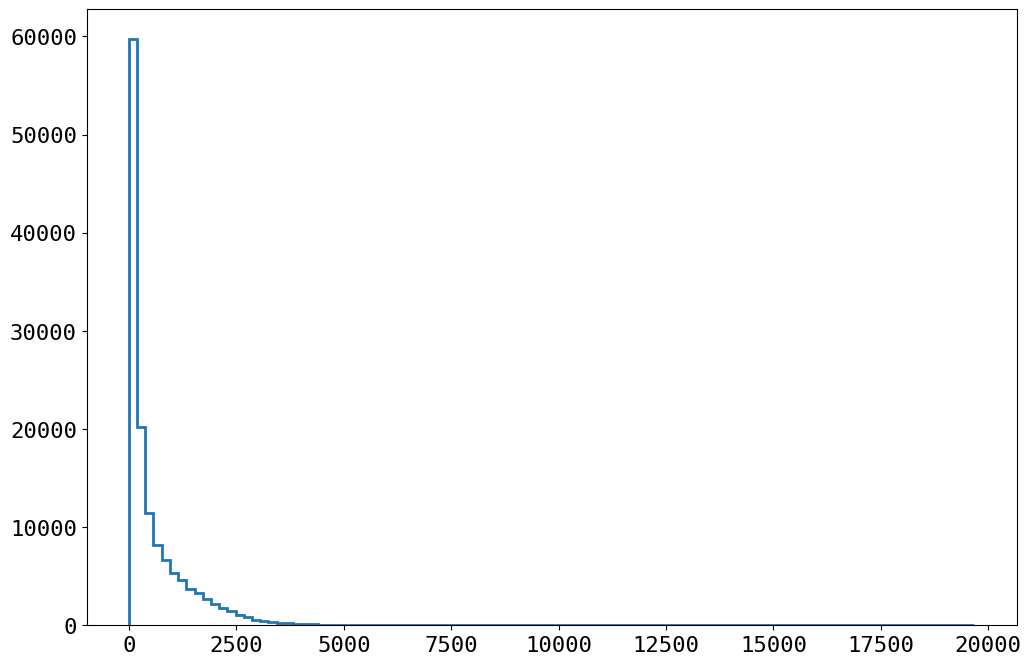

In [27]:
plt.hist(goodreads_reviews_subset["length"], bins="rice", histtype="step", lw=2)
# plt.xlim(0, np.quantile(goodreads_reviews_subset["length"], 0.95))
plt.show()

Even amongst the superusers, review lengths are quite heavy-tailed!

In [28]:
# removing non-unique data
goodreads_reviews_subset = goodreads_reviews_subset.unique()

In [29]:
# somewhat arbitrary choice; the min could easily be 200 and the max 6000
# 466 lower bound as that gets me ~50,000 reviews
goodreads_reviews_subset = goodreads_reviews_subset.filter(
    (pl.col("length") >= 466) & (pl.col("length") <= 5000)
)

len(goodreads_reviews_subset)

49949

In [30]:
# There are some users who have < 1000 reviews but most have more abundant numbers
# an equal distribution would have been ideal but not a deal breaker
goodreads_reviews_subset.group_by("user_id").len()

user_id,len
str,u32
"""8bb031b637de69eba020a8a466d111…",4758
"""422e76592e2717d5d59465d22d74d4…",4499
"""d8c39b3b11bb2da1c1d5c39f49669d…",820
"""dd9785b14664103617304996541ed7…",3419
"""97e2ce2141fa1c880967d78aec3c14…",2059
…,…
"""cf9e7ec0d08bd6db6f9330378c1239…",3422
"""e5905d648022af7b1309d82a1f4d25…",2530
"""459a6c4decf925aedd08e45045c0d8…",680


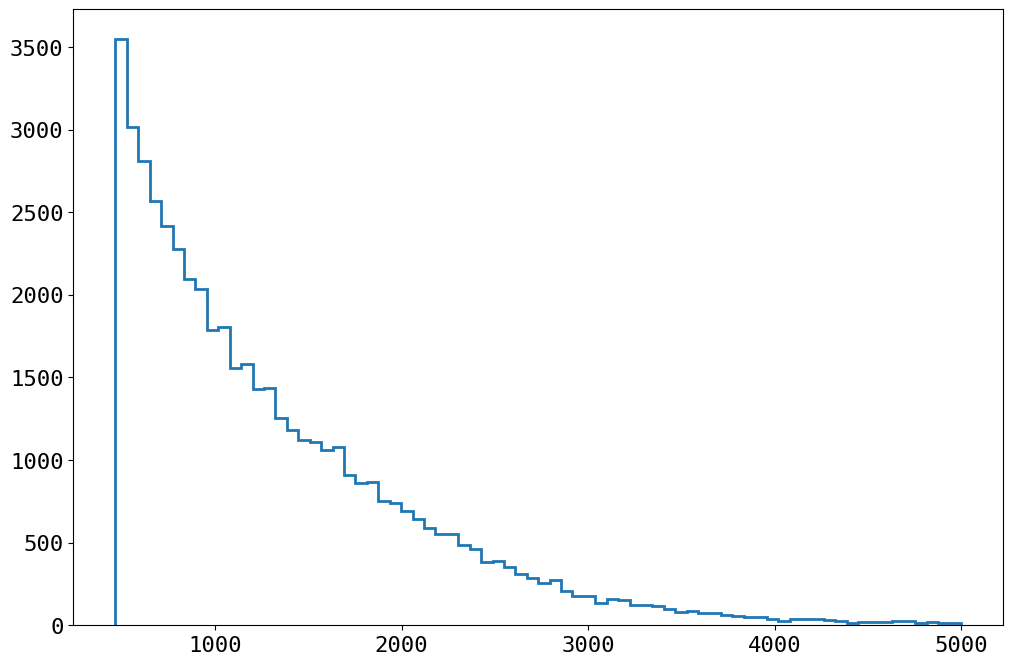

In [31]:
plt.hist(
    goodreads_reviews_subset["length"], 
    bins="rice", histtype="step", lw=2
)
plt.show()

In [32]:
# saving the ~50K selected reviews
goodreads_reviews_subset.write_csv("./data/refined/goodreads_text_list_subset_50K.csv")

In [33]:
# adding a length column to the saved CSV with reddit data
text_df = pl.read_csv("./data/refined/mega_txt_list.csv")

text_df.insert_column(
    2,
    pl.Series(
        "length",
        [len(i) for i in text_df["text"]]
    )
)

text_df

source,text,length
str,str,i64
"""suicidewatch_data.csv""","""Hello. I don't really know how…",4688
"""suicidewatch_data.csv""",""" I don't know what to say or…",3329
"""suicidewatch_data.csv""","""... and was asked to please 'w…",447
"""suicidewatch_data.csv""","""I saw it on twitter. Multiple …",877
"""suicidewatch_data.csv""","""If you say you're so depressed…",650
…,…,…
"""youthandgov_data.csv""","""If you could speak your mind t…",391
"""youthandgov_data.csv""","""so, this is my last year in ~~…",555
"""youthandgov_data.csv""","""I have been in the California …",390


In [34]:
# renaming goodreads df column to match the saved CSV
goodreads_reviews_subset = goodreads_reviews_subset.rename({
    "user_id": "source",
    "review_text": "text"
})

In [35]:
### adding the 50K selected reviews to the mega list 
# MEGA_TEXT_LIST.extend(goodreads_text_list_subset_50K)
# TEXT_SOURCE_LIST.extend(["goodreads"] * len(goodreads_text_list_subset_50K))

# adding goodreads data to the CSV
text_df = pl.concat([text_df, goodreads_reviews_subset])
text_df.write_csv("./data/refined/mega_txt_list.csv")

#### Downloading more Gutenberg books

I [forked a repository](https://github.com/SatriaImawan12/Top-Ranked-Gutenberg-Ebooks-Download) which had scraping code for Gutenberg books and ran it and 
downloaded 80 books. I am aiming to add ~40,000 text snippets form all these books, so 
I will randomly sample $\frac{40000}{80} = 500$ snippets from each of the books and add
 them to mega list. 

In [36]:
book_dir = "./data/raw/gutenberg_data/"

In [37]:
# snippets_from_gutenberg = []

# for name in book_dir:
#     book = 
    
#     random_snippet_length = random.randint(300, 5000)

*Something to check first:* random.randint() samples from a uniform distribution, but I
 know that the current distribution of text lengths from the reddit and good reads data
  isn't uniform. If I sample 40,000 snippets uniformly from the 80 books, the overall 
  distribution would remain the same. It is possible that the distribution of text 
  lengths in the testing set is on the longer side, so maybe it is better for the text 
  lengths to be slightly longer? I don't know; I don't have much beyond some vague 
  intuitions guiding my thinking/doubts here. 
      

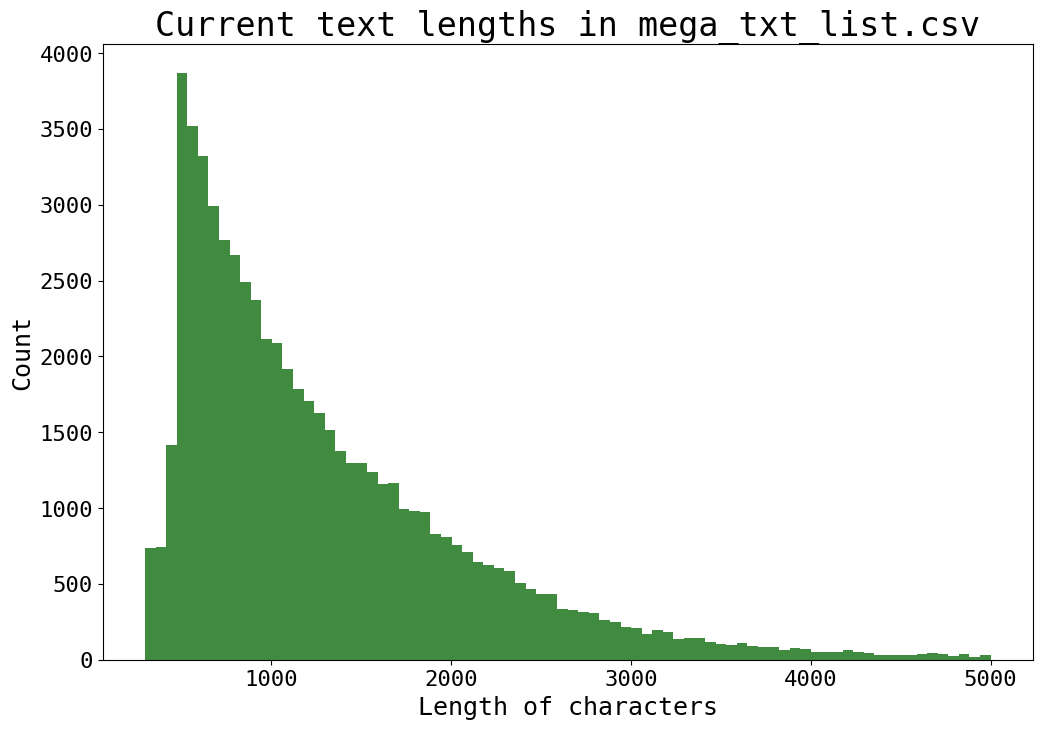

In [38]:
text_df = pl.read_csv("./data/refined/mega_txt_list.csv")

plt.hist([len(i) for i in text_df["text"]], 
         bins="rice", histtype="stepfilled", 
         alpha=0.75, color="darkgreen")
plt.title("Current text lengths in mega_txt_list.csv")
plt.xlabel("Length of characters")
plt.ylabel("Count")
plt.show()

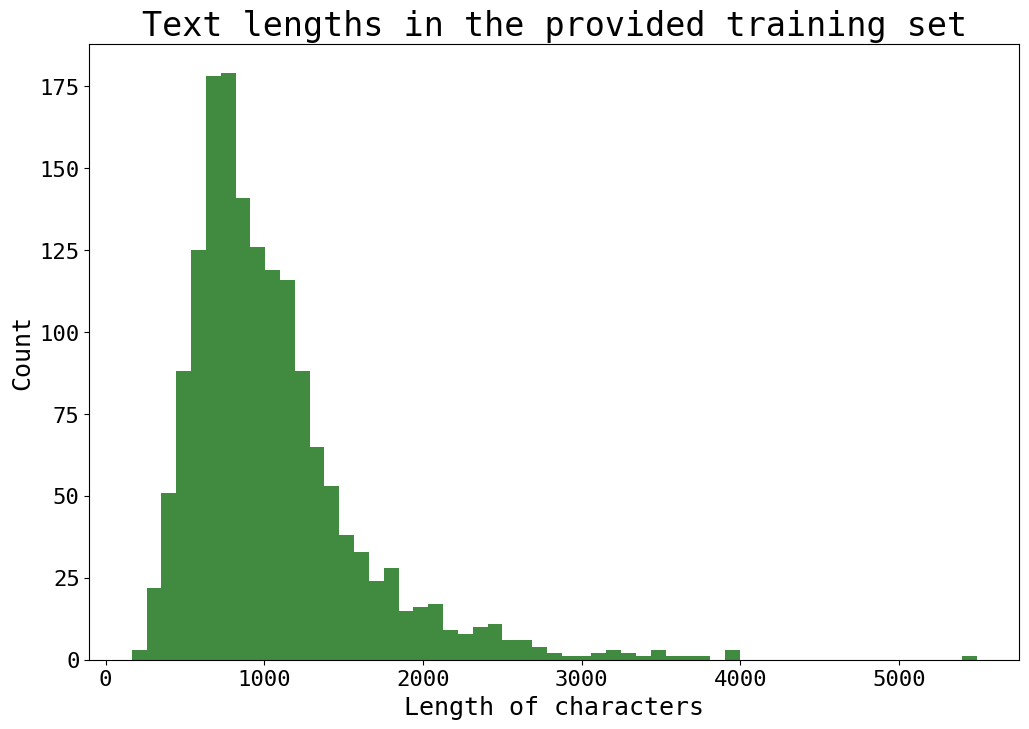

In [39]:
provided_training_set = pl.read_csv("./data/train.csv")

plt.hist([len(i) for i in provided_training_set["TEXT"]], 
         bins="fd", histtype="stepfilled", 
         alpha=0.75, color="darkgreen")
plt.title("Text lengths in the provided training set")
plt.xlabel("Length of characters")
plt.ylabel("Count")
plt.show()

For now, I will continue with uniform sampling of text but constrain the range from 
[300, 5000] to [800, 3000].  

In [40]:
# saving all books in a dictionary
book_names = [files for root, _, files in os.walk(book_dir)][0]
book_names = [i for i in book_names if i[-4:] == ".txt"]
gutenberg_books = {}

for name in book_names:
    try:
        with open(f"./data/raw/gutenberg_data/{name}", "r") as book_txt:
            book = book_txt.read()
            gutenberg_books[f"{name}"] = book
    except Exception as e:
        print(name)
        print(e)

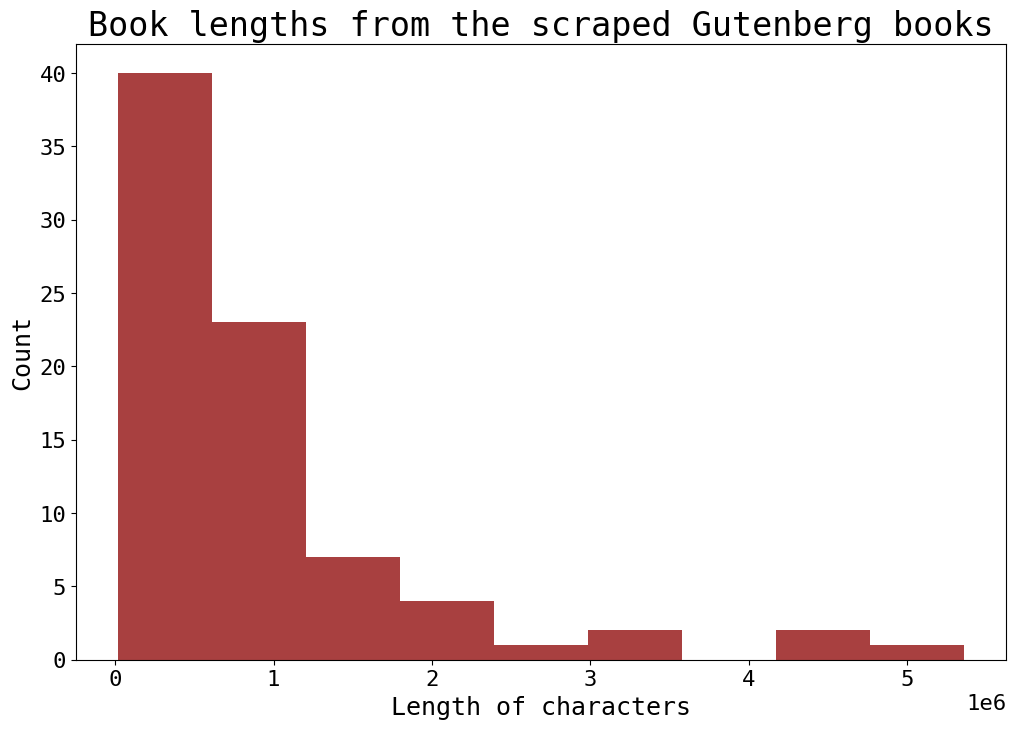

In [41]:
plt.hist([len(i) for i in gutenberg_books.values()], 
         bins="rice", histtype="stepfilled", 
         alpha=0.75, color="darkred")
plt.title("Book lengths from the scraped Gutenberg books")
plt.xlabel("Length of characters")
plt.ylabel("Count")
plt.show()

In [42]:
# estimating the total amount of text I can draw from the books
# sum([len(i) ... gutenberg_books.values()]) is the number of characters in the books
# 0.949 — scaling factor, I varied this to check how much I could sample from the books
print(
    sum([len(i) for i in gutenberg_books.values()]) 
    - 0.949 * 40000 * np.median(range(800, 3000))
)

12500.0


##### Other issues
1. Book lengths vary, so instead of 500 snippets from each book, I will have to scrape 
a variable amount of text from each of the books.
2. I think going with 30,000 snippets instead of 40,000 would be better as there may not be enough text in all the books combined for me to scrape 40,000 * 1900 characters; 1900 is the median of the uniform range [800, 3000], and I am using that as proxy to 
estimate if the books have enough content.
2. Nearly every book has a table of contents; some have a preface; a few have notes 
from transcribers. It is fine if the latter two make it into the snippets but the table
 of contents, publishing information, the title page, etc. would be better ignored. 

In [43]:
# snippets_from_gutenberg = []
# 
# counter = 0
# while counter < 30000:
#     for book in list(gutenberg_books.values())[3:4]:        
#         # skipping the first ten percent of the book which should contain the tables of
#         # contents and other less useful text snippets
#         book = book[int(0.1 * len(book)):]
#         
#         random_text_length = random.randint(800, 3000)
#         
#         snippets_from_gutenberg.append(book[random_text_length: random_text_length])

In [44]:
gutenberg_books.keys()

dict_keys(['Grimms.txt', 'The Republic by Plato .txt', 'Leviathan by Thomas Hobbes .txt', 'Beyond Good and Evil by Friedrich Wilhelm Nietzsche .txt', 'War and Peace by graf Leo Tolstoy .txt', 'Moby Dick.txt', 'Crime and Punishment by Fyodor Dostoyevsky .txt', 'Twenty years after by Alexandre Dumas and Auguste Maquet .txt', 'The Wonderful Wizard of Oz by L.txt', 'Metamorphosis by Franz Kafka .txt', 'Calculus Made Easy by Silvanus P.txt', 'The Enchanted April by Elizabeth Von Arnim .txt', 'Middlemarch by George Eliot .txt', 'The Prince by Niccol.txt', 'A Room with a View by E.txt', 'The Devil is an Ass by Ben Jonson .txt', 'My Life .txt', 'Ulysses by James Joyce .txt', 'Thus Spake Zarathustra.txt', 'Wuthering Heights by Emily Bront.txt', 'Les Mis.txt', 'On Liberty by John Stuart Mill .txt', 'Little Women by Louisa May Alcott .txt', 'The Great Gatsby.txt', 'Dracula by Bram Stoker .txt', 'Alice.txt', 'The Adventures of Sherlock Holmes by Arthur Conan Doyle .txt', 'The Tragical History of D

##### Updated method 
It seems complicated to go through all the books, pick out a paragraph of variable 
length, ignore footnotes and chapter titles, and append the relevant portion for the 80
 books. I am overcomplicating the text extraction. It would be much easier to divide 
 each book into paragraphs using the separator `\n\n`, removing the obvious short 
 sentences (which will most likely be contents or footnotes or other unnecessary text),
  and then appending them all to a large list of texts. 

In [45]:
unique_book_para = set()

# Processing all books and storing paragraphs
books_paragraph_ized_names = []
books_paragraph_ized_text = []
books_paragraph_ized_lengths = []

for name, text in gutenberg_books.items():
    book_paragraphs = [para.strip() for para in text.split("\n\n") if para.strip()]
    for para in book_paragraphs:
        if para not in unique_book_para:
            unique_book_para.add(para)
            books_paragraph_ized_names.append(name)
            books_paragraph_ized_text.append(para)
            books_paragraph_ized_lengths.append(len(para))


In [46]:
len(books_paragraph_ized_text) == len(np.unique(books_paragraph_ized_text))

True

In [47]:
books_paragraph_ized_df = pl.DataFrame({
    "source": books_paragraph_ized_names,
    "text": books_paragraph_ized_text,
    "length": books_paragraph_ized_lengths
})

books_paragraph_ized_df

source,text,length
str,str,i64
"""Grimms.txt""","""﻿ *** START OF THE PROJECT GUT…",52
"""Grimms.txt""","""ANONYMITY""",9
"""Grimms.txt""","""_An Enquiry_""",12
"""Grimms.txt""","""THE HOGARTH ESSAYS.""",19
"""Grimms.txt""","""I. MR. BENNETT AND MRS. BROWN.…",66
…,…,…
"""White Nights and Other Stories…","""And the traveller girds himsel…",88
"""White Nights and Other Stories…","""The Afterthought""",16
"""White Nights and Other Stories…","""Hear my cry, O God the Reader;…",535


In [48]:
# checking if there are duplicates
len(books_paragraph_ized_df) == len(books_paragraph_ized_df.unique())

True

In [49]:
# removing lines in the paragraphs with less than 500 characters
# this should take care of contents, publisher notes, footnotes, etc.

books_paragraph_ized_df1 = books_paragraph_ized_df.filter(
    (pl.col("length") >= 500) & (pl.col("length") <= 5000)
)
print(len(books_paragraph_ized_df1))

33866


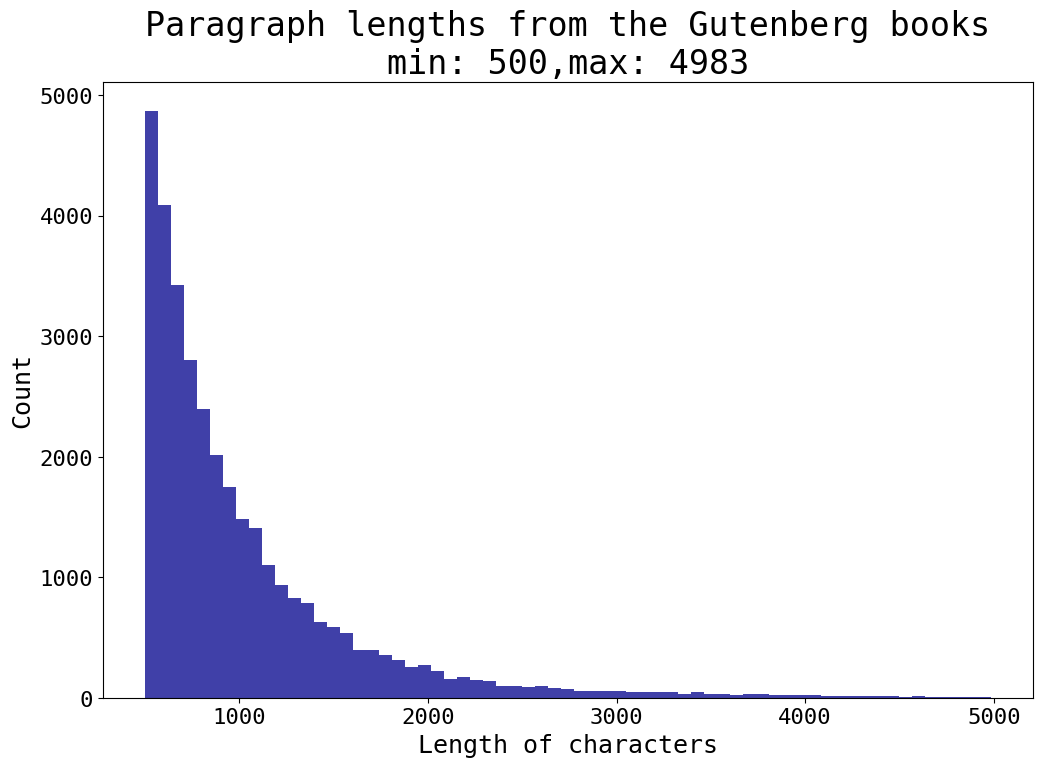

In [50]:
plt.hist(
    books_paragraph_ized_df1["length"], 
    bins="rice", histtype="stepfilled", 
    alpha=0.75, color="darkblue"
)

plt.title(f'Paragraph lengths from the Gutenberg books\n'
          f'min: {min(books_paragraph_ized_df1["length"])},'
          f'max: {max(books_paragraph_ized_df1["length"])}')
plt.xlabel("Length of characters")
plt.ylabel("Count")
plt.show()

In [51]:
# now there are some extremely long book paragraphs and I can still use those after 
# splitting them into smaller chunks

books_paragraph_ized_df2 = books_paragraph_ized_df.filter(
    (pl.col("length") >= 5000)
)
print(len(books_paragraph_ized_df2))

163


In [52]:
very_long_paragraphs_name = []
very_long_paragraphs_text = []
very_long_paragraphs_len = []

sentence_ends = ['. ', '."', '.”']

# this loop sweeps through the large paragraphs and splits 
# them into smaller paragraphs of lengths ~3000 each 
for row_num in tqdm(range(len(books_paragraph_ized_df2))):
    min_sweep = 2500
    max_sweep = 3500 + 1
    window = 2
    
    end_point = 0
    sweep = min_sweep
    
    while True:
        text = books_paragraph_ized_df2["text"][row_num]
        source = books_paragraph_ized_df2["source"][row_num]

        if text[sweep:sweep + window] in sentence_ends:
            text_snippet = text[end_point:sweep + window]
            very_long_paragraphs_name.append(source)
            very_long_paragraphs_text.append(text_snippet)
            very_long_paragraphs_len.append(len(text_snippet))
            # print(text[end_point:sweep + window])
            end_point = sweep + window
            
            if len(text[sweep + window:]) < max_sweep:
                text_snippet = text[sweep + window:]
                
                very_long_paragraphs_name.append(source)
                very_long_paragraphs_text.append(text_snippet)
                very_long_paragraphs_len.append(len(text_snippet))
                break
            
            sweep = end_point + min_sweep
            
        # for one of the items in the list, the loop wouldn't end
        # I checked and found that that piece of text was not in english
        # this should catch that, but I also need to remove non-English text
        # from the list of all paragraphs
        if sweep + window == len(text):
            break
            
        sweep += 1   

100%|██████████| 163/163 [00:01<00:00, 88.95it/s]


In [53]:
books_paragraph_ized_df2_split = pl.DataFrame({
    "source": very_long_paragraphs_name,
    "text": very_long_paragraphs_text,
    "length": very_long_paragraphs_len
})

books_paragraph_ized_df2_split

source,text,length
str,str,i64
"""Leviathan by Thomas Hobbes .tx…","""From what has been related her…",2597
"""Leviathan by Thomas Hobbes .tx…",""" Castruccio said to one who pr…",2541
"""Leviathan by Thomas Hobbes .tx…","""Castruccio used to say that th…",3078
"""Twenty years after by Alexandr…","""“Two offences of a very differ…",2598
"""Twenty years after by Alexandr…","""But I shall not scruple to ass…",2758
…,…,…
"""Doctrina Christiana .txt""","""“ ‘Receiving bread from us, th…",2585
"""Doctrina Christiana .txt""","""The most painful secrets of th…",2422
"""Doctrina Christiana .txt""","""“I know you would all like it …",2661


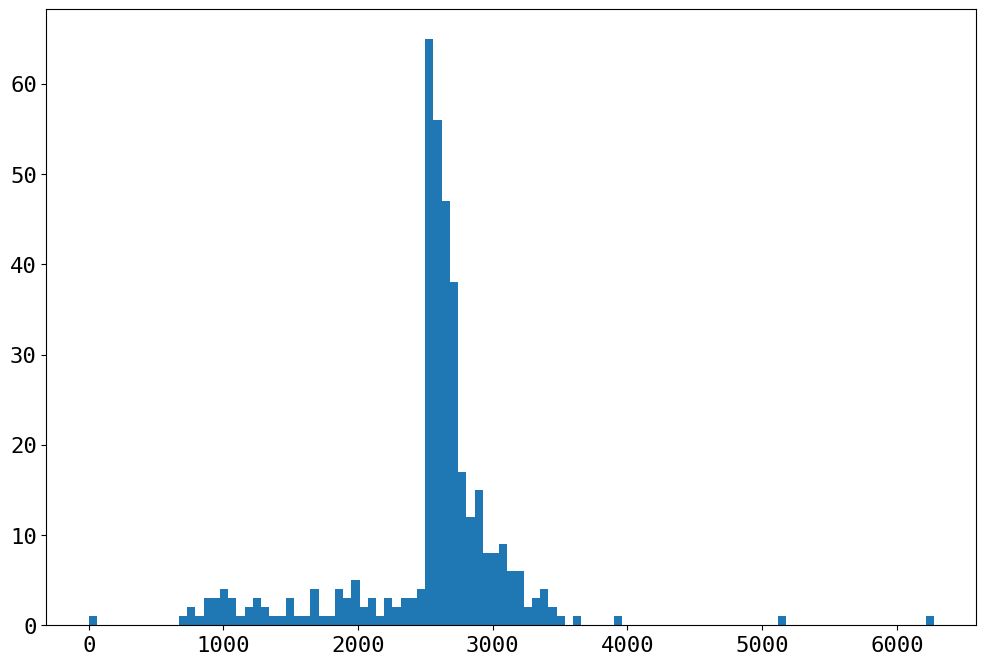

In [54]:
plt.hist(books_paragraph_ized_df2_split["length"], bins="fd")
plt.show()

In [55]:
[i for i in books_paragraph_ized_df2_split["text"] if len(i) < 500]

['']

This is perfect! Now, I need to remove the `""` from `very_long_paragraphs_split` and 
non-English text from `books_paragraphs`.

In [56]:
books_paragraph_ized_df2_split = books_paragraph_ized_df2_split.filter(
    (pl.col("length") > 10)
)

books_paragraph_ized_df2_split

source,text,length
str,str,i64
"""Leviathan by Thomas Hobbes .tx…","""From what has been related her…",2597
"""Leviathan by Thomas Hobbes .tx…",""" Castruccio said to one who pr…",2541
"""Leviathan by Thomas Hobbes .tx…","""Castruccio used to say that th…",3078
"""Twenty years after by Alexandr…","""“Two offences of a very differ…",2598
"""Twenty years after by Alexandr…","""But I shall not scruple to ass…",2758
…,…,…
"""Doctrina Christiana .txt""","""“ ‘Receiving bread from us, th…",2585
"""Doctrina Christiana .txt""","""The most painful secrets of th…",2422
"""Doctrina Christiana .txt""","""“I know you would all like it …",2661


In [57]:
# combining the two book text dfs together
books_paragraphs_proper_df =  pl.concat([books_paragraph_ized_df1, books_paragraph_ized_df2_split])

In [58]:
print(len(books_paragraphs_proper_df))

34240


In [59]:
# removing non-English text snippets using the langdetect library
from langdetect import detect

In [60]:
books_paragraphs_proper_df = books_paragraphs_proper_df.filter(
    books_paragraphs_proper_df["text"].map_elements(lambda x: detect(x) == "en")
)

/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_75472/2296715179.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  books_paragraphs_proper_df["text"].map_elements(lambda x: detect(x) == "en")


In [61]:
len(books_paragraphs_proper_df)

32368

In [62]:
# saving the file as a csv
books_paragraphs_proper_df.write_csv(
    "./data/refined/gutenberg_expansion_pack.csv"
)

# appending the file into the existing large CSV with reddit and book review text
text_df = pl.read_csv("./data/refined/mega_txt_list.csv")

text_df = pl.concat([text_df, books_paragraphs_proper_df])
text_df.write_csv("./data/refined/mega_txt_list.csv")

#### Another modification: removing non-English text from the whole dataset
I did this for text from the books but not for text from reddit and goodreads!


In [63]:
text_df = text_df.filter(
    text_df["text"].map_elements(lambda x: detect(x) == "en")
)

print(len(text_df))

/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_75472/3368909392.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  text_df["text"].map_elements(lambda x: detect(x) == "en")


91336


In [64]:
text_df.write_csv("./data/refined/mega_txt_list.csv")

##### Another check: what does the character length distribution look like for the new data?

(And how does it compare to the given data?)

Since I later plan to split these sentences and join them, it possible that splitting 
and joining smaller sequences wouldn't be valuable for the model to learn as there 
won't be sufficient context. So maybe it would be better to remove sequences that are 
below a threshold.

In [65]:
provided_training_set = pl.read_csv("./data/train.csv")

In [66]:
provided_training_set_text_split = []

for text in provided_training_set["TEXT"]:
    split_text = text.split(" [SNIPPET] ")
    provided_training_set_text_split.append(split_text)

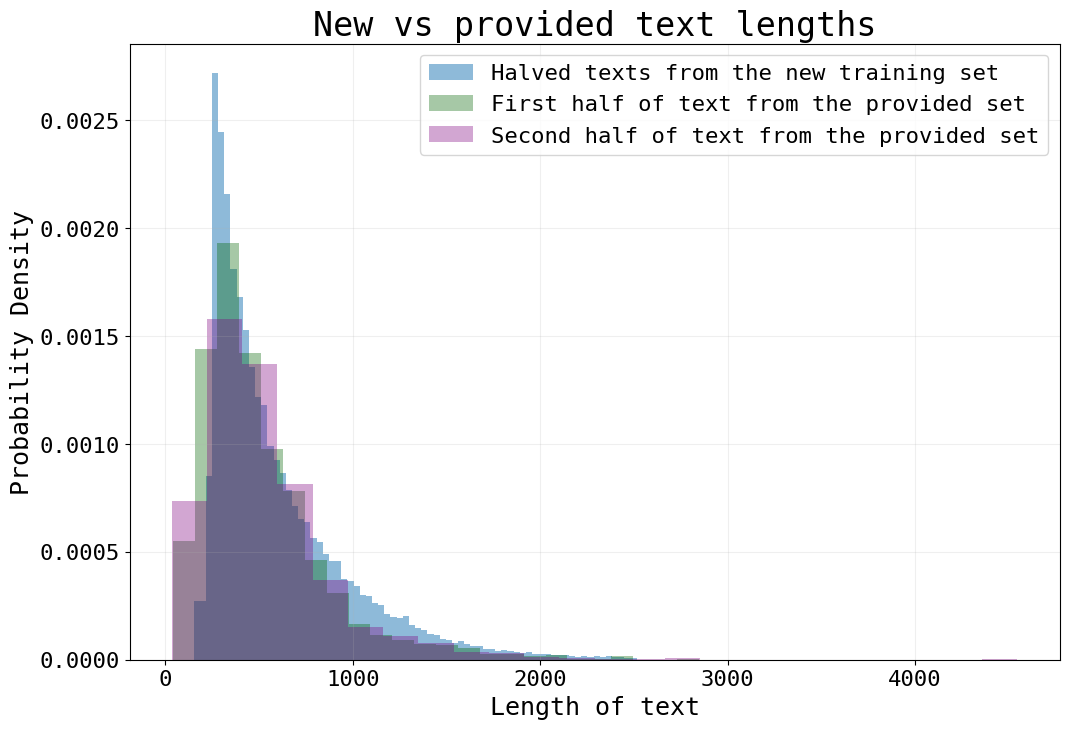

In [67]:
plt.hist(
    [i // 2 for i in text_df["length"]], 
    bins="rice",
    histtype="stepfilled",
    alpha=0.5,
    label="Halved texts from the new training set",
    density=True
)

plt.hist(
    [len(i[0]) for i in provided_training_set_text_split],
    bins="rice", 
    histtype="stepfilled", 
    alpha=0.35, color="darkgreen",
    label="First half of text from the provided set",
    density=True,
)

plt.hist(
    [len(i[1]) for i in provided_training_set_text_split],
    bins="rice", histtype="stepfilled", 
    alpha=0.35, color="purple",
    label="Second half of text from the provided set",
    density=True
)

plt.title("New vs provided text lengths")
plt.xlabel("Length of text")
plt.ylabel("Probability Density")

plt.grid(alpha=0.2)
plt.legend(fontsize=16)

plt.show()

# plt.savefig(
# "new_vs_provided_text_lengths.png "
# )

Huh, roughly similar if not a tad bit better!

In [68]:
print(
    f"Total number of new samples: {len(text_df)}\n"
    f"Increase compared to the given training set: "
    f"{int(np.round(len(text_df) / len(train)).item())}"
)

Total number of new samples: 91336
Increase compared to the given training set: 57


There are already >90,000 entries in the expanded text list. This is a 57x 
increase in fine-tuning data compared to the provided training data. All these 
entries are from several authors, each with their style of writing. The idea behind 
this exercise was radically increasing the training set size for fine-tuning the model 
with the hopes that scaling works and the increase in data would yield better 
performance. Instead of scraping even more text, now is a good time to test if this bet 
worked out!

If there isn't a meaningful increase in the F1 score, then gathering more data wouldn't
 be the best way to proceed. I will further clean and mix-and-match the gathered text 
 so far to create more training data in the notebook titled `prepping_new_data.ipynb`. 
 Then, I will fine-tune the model using the newly acquired data and observe the model's
  performance. 